In [14]:
%pylab inline
%load_ext autoreload
%autoreload 2

from GPyOpt.methods import BayesianOptimization
import GPy
import GPyOpt
from numpy.random import seed
from tqdm import *
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# # define scikit-learn style colormap transform for RGBA outputs (label / discrete)
# helper code to map arbitrary class label nparray into rgb color that plato read
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn.apionly as sns
from sklearn import preprocessing

,T*,r* (vapor),r* (liquid),p*,Unnamed: 4,Saturation Data Generated from Johnson et al. EOS
count,613.000000,613.000000,613.000000,613.000000,0.0,0.0
mean,1.006000,0.053613,0.678753,0.039169,NaN,NaN
std,0.177102,0.057797,0.115646,0.036438,NaN,NaN
min,0.700000,0.002012,0.338258,0.001381,NaN,NaN
25%,0.853000,0.009999,0.601544,0.007936,NaN,NaN
50%,1.006000,0.030999,0.697953,0.026221,NaN,NaN
75%,1.159000,0.078556,0.774092,0.063714,NaN,NaN
max,1.312000,0.282726,0.843237,0.129383,NaN,NaN


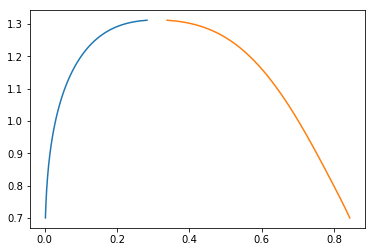

In [16]:
import pandas as pd
lj = pd.read_excel('/Users/Chengyu/Google Drive/Presentation/paper_active_learning/LJ/lj_092506.xls', sheetname=4)
plt.plot(lj['r* (vapor)'], lj['T*'])
plt.plot(lj['r* (liquid)'], lj['T*'])
lj.head()
lj.describe()

In [17]:
LJ_BOUNDS = [(0,0.9), (0.7, 1.5)]

In [30]:
def lj_phase(r, t):
    MAX_RHO_VAPOR = 0.282726
    MIN_RHO_LIQ   = 0.338258
    MAX_RHO_LIQ   = 0.843237
    
    if r <= MAX_RHO_VAPOR:
        idx = np.argmin(np.abs(r - lj['r* (vapor)']))
        t_c = lj['T*'].iloc[idx]
        return (t > t_c) * 2 - 1
    
    if r >= MIN_RHO_LIQ and r <= MAX_RHO_LIQ:
        idx = np.argmin(np.abs(r - lj['r* (liquid)']))
        t_c = lj['T*'].iloc[idx]
        return (t > t_c) * 2 - 1
    
    if r >= MAX_RHO_LIQ:
        return 1
    
    # in critical region
    return (t > np.max(lj['T*'])) * 2 - 1

In [31]:

# # define scikit-learn style colormap transform for RGBA outputs (continous)
class RGBAContinuousTransformer():
    def __init__(self, colormap_type, resolution):
        self.colormap_type = colormap_type
        self.resolution = resolution
    
    def fit(self, data):
        self.max_ = np.max(data)
        self.min_ = np.min(data)
        self.range_ = self.max_ - self.min_
        self.seamap = sns.color_palette(self.colormap_type, n_colors=self.resolution)
        self.norm = mpl.colors.Normalize(vmin=self.min_, vmax=self.max_)
        self.colormap = cm.ScalarMappable(norm=self.norm, cmap=mpl.colors.ListedColormap(self.seamap))

    def transform(self, data):
        if len(data.shape) != 1 and not (1 in data.shape):
            raise Exception("1d array only is accepted")
        ret = self.colormap.to_rgba(data)
        ret = ret.reshape((len(data),4))
        return ret
        
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)
    
    def palplot(self):
        sample = np.arange(self.min_, self.max_, self.range_ / self.resolution)
        sns.palplot(self.transform(sample))
        print("Sample Min:" + str(self.min_) + ", Sample Max:" + str(self.max_) + ", Resolution:" + str(self.resolution))

In [32]:
from GPyOpt.objective_examples.experiments2d import function2d
import numpy as np
class SynthObj2d(function2d):
    '''
    Cosines function
    
    :param bounds: the box constraints to define the domain in which the function is optimized.
    :param sd: standard deviation, to generate noisy evaluations of the function.
    '''
    def __init__(self,bounds=None,sd=None):
        self.input_dim = 2
        if bounds == None: self.bounds = LJ_BOUNDS
        else: self.bounds = bounds
        self.min = [(0, 0.7)]
        self.fmin = 0
        if sd==None: self.sd = 0
        else: self.sd=sd
        self.name = 'MyObj'

    def f(self,X):
#         X = reshape(X,self.input_dim)
        n = X.shape[0]
        if X.shape[1] != self.input_dim:
            return 'Wrong input dimension'
        else:
#             fval = -(np.sin(np.sqrt(X[:,0])*1.1)<X[:,1]/10)*2 - 1
            fval = np.zeros((n, 1))
            for i in range(n):
                fval[i, 0] = lj_phase(X[i,0], X[i, 1])
            
            if self.sd ==0:
                noise = np.zeros(n).reshape(n,1)
            else:
                noise = np.random.normal(0,self.sd,n).reshape(n,1)
            return -fval.reshape(n,1) + noise


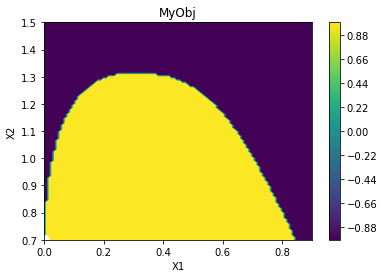

In [33]:
obj = SynthObj2d()
myf = obj.f
obj.plot()

In [34]:
from itertools import product
from sklearn.neighbors import KNeighborsClassifier


def plot_contour(myProblem, obj, ite, colormap, precision=50, level=0):
    bounds = myProblem.space.get_bounds()
    gridx = np.linspace(bounds[0][0], bounds[0][1], precision)
    gridy = np.linspace(bounds[1][0], bounds[1][1], precision)
    
    xv, yv = np.meshgrid(gridx, gridy)
    zv = np.zeros((precision, precision))
    true_zv = np.zeros((precision, precision))
    
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(myProblem.X, myProblem.Y)
    
    for i in range(len(xv)):
        for j in range(len(xv)):
            zv[i,j] = myProblem.model.predict(np.array([xv[i,j],yv[i,j]]).T)[0]
#             zv[i,j] = knn.predict(np.array([xv[i,j],yv[i,j]]).reshape((1,-1)))[0]
            true_zv[i,j] = obj.f(np.array([[xv[i,j],yv[i,j]]]))
    ct = plt.contour(xv, yv, zv,levels=[0], colors=colormap.transform(np.array([ite])), linewidths=5)
    ct.collections[0].set_label('Active Learning with 55 samples')
    plt.legend()
    # round zv to int value
    zv = (zv>0) * 2 - 1
    return np.sum(zv!=true_zv) / precision**2

In [35]:
bounds = [{'name': 'Density (r)', 'type': 'continuous', 'domain': LJ_BOUNDS[0]},
          {'name': 'Temperature (T)', 'type': 'continuous', 'domain': LJ_BOUNDS[1]}]
max_iter = 10

In [36]:
bounds

[{'domain': (0, 0.9), 'name': 'Density (r)', 'type': 'continuous'},
 {'domain': (0.7, 1.5), 'name': 'Temperature (T)', 'type': 'continuous'}]

In [37]:
init = array([[ 0.23199582,  1.28790304],
       [ 0.25400738,  0.80391961],
       [ 0.29361109,  1.41717859],
       [ 0.19652469,  1.46909882],
       [ 0.34741252,  1.43525204]])

In [38]:
myProblem_batch = BayesianOptimization(myf,bounds,acquisition_type="BinaryT",
                                       X = init,
                                 evaluator_type = 'local_penalization',
                                 batch_size = 5,
                                 num_cores = 1,)

r
[ 0.13363341]
r
[ 0.13363341  0.13363341]
r
[ 0.13363341  0.13363341  0.13363341]
r
[ 0.13363341  0.13363341  0.13363341  0.13196253]


  0%|          | 0/38 [00:00<?, ?it/s]

r
[ 0.13915854]
r
[ 0.13915854  0.13915854]
r
[ 0.13915854  0.13915854  0.13915854]
r
[ 0.13915854  0.13915854  0.13915854  0.13741858]
r
[ 0.07023182]
r
[ 0.07023182  0.07023182]
r
[ 0.07023182  0.07023182  0.07023182]
r
[ 0.07023182  0.07023182  0.07023182  0.07023182]


  3%|▎         | 1/38 [00:03<02:08,  3.47s/it]

r
[ 0.07298951]
r
[ 0.07298951  0.07298951]
r
[ 0.07298951  0.07298951  0.07298951]
r
[ 0.07298951  0.07298951  0.07298951  0.07298951]
r
[ 0.15253376]
r
[ 0.15253376  0.15253376]
r
[ 0.15253376  0.15253376  0.15253376]
r
[ 0.15253376  0.15253376  0.15253376  0.15253376]


  5%|▌         | 2/38 [00:07<02:13,  3.71s/it]

r
[ 0.15253376]
r
[ 0.15253376  0.15253376]
r
[ 0.15253376  0.15253376  0.15253376]
r
[ 0.15253376  0.15253376  0.15253376  0.15253376]
r
[ 0.11986495]
r
[ 0.11986495  0.11986495]
r
[ 0.11986495  0.11986495  0.11986495]
r
[ 0.11986495  0.11986495  0.11986495  0.11986495]


  8%|▊         | 3/38 [00:13<02:28,  4.24s/it]

r
[ 0.12440015]
r
[ 0.12440015  0.12440015]
r
[ 0.12440015  0.12440015  0.12440015]
r
[ 0.12440015  0.12440015  0.12440015  0.12439354]
r
[ 0.25593271]
r
[ 0.25593271  0.25593271]
r
[ 0.25593271  0.25593271  0.25593271]
r
[ 0.25593271  0.25593271  0.25593271  0.25593271]


 11%|█         | 4/38 [00:17<02:23,  4.22s/it]

r
[ 0.29534294]
r
[ 0.29534294  0.29534294]
r
[ 0.29534294  0.29534294  0.29534294]
r
[ 0.29534294  0.29534294  0.29534294  0.29534294]
r
[ 0.32699448]
r
[ 0.32699448  0.32699448]
r
[ 0.32699448  0.32699448  0.32699448]
r
[ 0.32699448  0.32699448  0.32699448  0.32699448]


 13%|█▎        | 5/38 [00:21<02:16,  4.13s/it]

r
[ 0.32699448]
r
[ 0.32699448  0.32699448]
r
[ 0.32699448  0.32699448  0.32699448]
r
[ 0.32699448  0.32699448  0.32699448  0.32699448]
r
[ 0.30776489]
r
[ 0.30776489  0.30776489]
r
[ 0.30776489  0.30776489  0.30776489]
r
[ 0.30776489  0.30776489  0.30776489  0.30776489]


 16%|█▌        | 6/38 [00:25<02:10,  4.09s/it]

r
[ 0.27711327]
r
[ 0.27711327  0.27711327]
r
[ 0.27711327  0.27711327  0.27711327]
r
[ 0.27711327  0.27711327  0.27711327  0.27711327]
r
[ 0.23190594]
r
[ 0.23190594  0.23190594]
r
[ 0.23190594  0.23190594  0.23190594]
r
[ 0.23190594  0.23190594  0.23190594  0.23190594]


 18%|█▊        | 7/38 [00:29<02:03,  3.98s/it]

r
[ 0.2410741]
r
[ 0.2410741  0.2410741]
r
[ 0.2410741  0.2410741  0.2410741]
r
[ 0.2410741  0.2410741  0.2410741  0.2410741]
r
[ 0.24384356]
r
[ 0.24384356  0.24384356]
r
[ 0.24384356  0.24384356  0.24384356]
r
[ 0.24384356  0.24384356  0.24384356  0.24384356]


 21%|██        | 8/38 [00:33<02:05,  4.17s/it]

r
[ 0.03650799]
r
[ 0.03650799  0.03644042]
r
[ 0.03650799  0.03644042  0.03650799]
r
[ 0.03650799  0.03644042  0.03650799  0.03632461]
r
[ 0.03581507]
r
[ 0.03581507  0.03576471]
r
[ 0.03581507  0.03576471  0.03581507]
r
[ 0.03581507  0.03576471  0.03581507  0.03581507]


 24%|██▎       | 9/38 [00:36<01:53,  3.93s/it]

r
[ 0.03924835]
r
[ 0.03924835  0.03919316]
r
[ 0.03924835  0.03919316  0.03924835]
r
[ 0.03924835  0.03919316  0.03924835  0.03924835]
r
[ 0.03065229]
r
[ 0.03065229  0.03065229]
r
[ 0.03065229  0.03065229  0.03045848]
r
[ 0.03065229  0.03065229  0.03045848  0.03034179]


 26%|██▋       | 10/38 [00:40<01:46,  3.80s/it]

r
[ 0.0326461]
r
[ 0.0326461  0.0326461]
r
[ 0.0326461   0.0326461   0.03243968]
r
[ 0.0326461   0.0326461   0.03243968  0.0323154 ]
r
[ 0.32495975]
r
[ 0.32495975  0.32495975]
r
[ 0.32495975  0.32495975  0.32495975]
r
[ 0.32495975  0.32495975  0.32495975  0.32495975]


 29%|██▉       | 11/38 [00:44<01:40,  3.71s/it]

r
[ 0.31300201]
r
[ 0.31300201  0.31300201]
r
[ 0.31300201  0.31300201  0.31300201]
r
[ 0.31300201  0.31300201  0.31300201  0.31300201]
r
[ 0.28083752]
r
[ 0.28083752  0.28083752]
r
[ 0.28083752  0.28083752  0.28083752]
r
[ 0.28083752  0.28083752  0.28083752  0.28083752]


 32%|███▏      | 12/38 [00:47<01:37,  3.75s/it]

r
[ 0.28083752]
r
[ 0.28083752  0.28083752]
r
[ 0.28083752  0.28083752  0.28083752]
r
[ 0.28083752  0.28083752  0.28083752  0.28083752]
r
[ 0.27345277]
r
[ 0.27345277  0.27345277]
r
[ 0.27345277  0.27345277  0.27345277]
r
[ 0.27345277  0.27345277  0.27345277  0.27345277]


 34%|███▍      | 13/38 [00:51<01:34,  3.79s/it]

r
[ 0.27153275]
r
[ 0.27153275  0.27153275]
r
[ 0.27153275  0.27153275  0.27153275]
r
[ 0.27153275  0.27153275  0.27153275  0.27153275]
r
[ 0.22730921]
r
[ 0.22730921  0.22730921]
r
[ 0.22730921  0.22730921  0.22730921]
r
[ 0.22730921  0.22730921  0.22730921  0.22730921]


 37%|███▋      | 14/38 [00:55<01:31,  3.80s/it]

r
[ 0.22727253]
r
[ 0.22727253  0.22727253]
r
[ 0.22727253  0.22727253  0.22727253]
r
[ 0.22727253  0.22727253  0.22727253  0.22727253]
r
[ 0.21086011]
r
[ 0.21086011  0.21086011]
r
[ 0.21086011  0.21086011  0.21086011]
r
[ 0.21086011  0.21086011  0.21086011  0.21086011]


 39%|███▉      | 15/38 [00:59<01:28,  3.87s/it]

r
[ 0.21086036]
r
[ 0.21086036  0.21086036]
r
[ 0.21086036  0.21086036  0.21086036]
r
[ 0.21086036  0.21086036  0.21086036  0.21086036]
r
[ 0.19157123]
r
[ 0.19157123  0.19157123]
r
[ 0.19157123  0.19157123  0.19157123]
r
[ 0.19157123  0.19157123  0.19157123  0.19157123]


 42%|████▏     | 16/38 [01:03<01:26,  3.94s/it]

r
[ 0.19157117]
r
[ 0.19157117  0.19157117]
r
[ 0.19157117  0.19157117  0.19157117]
r
[ 0.19157117  0.19157117  0.19157117  0.19157117]
r
[ 0.17597928]
r
[ 0.17597928  0.17597928]
r
[ 0.17597928  0.17597928  0.17597928]
r
[ 0.17597928  0.17597928  0.17597928  0.17597928]


 45%|████▍     | 17/38 [01:07<01:24,  4.03s/it]

r
[ 0.17597928]
r
[ 0.17597928  0.17597928]
r
[ 0.17597928  0.17597928  0.17597928]
r
[ 0.17597928  0.17597928  0.17597928  0.17597928]
r
[ 0.16067419]
r
[ 0.16067419  0.16067419]
r
[ 0.16067419  0.16067419  0.16067419]
r
[ 0.16067419  0.16067419  0.16067419  0.16067419]


 47%|████▋     | 18/38 [01:12<01:20,  4.04s/it]

r
[ 0.17227036]
r
[ 0.17227036  0.17227036]
r
[ 0.17227036  0.17227036  0.17227036]
r
[ 0.17227036  0.17227036  0.17227036  0.17227036]
r
[ 0.13954833]
r
[ 0.13954833  0.13954833]
r
[ 0.13954833  0.13954833  0.13954833]
r
[ 0.13954833  0.13954833  0.13954833  0.13954833]


 50%|█████     | 19/38 [01:16<01:17,  4.06s/it]

r
[ 0.13954828]
r
[ 0.13954828  0.13954828]
r
[ 0.13954828  0.13954828  0.13954828]
r
[ 0.13954828  0.13954828  0.13954828  0.13954828]
r
[ 0.1555336]
r
[ 0.1555336  0.1555336]
r
[ 0.1555336  0.1555336  0.1555336]
r
[ 0.1555336  0.1555336  0.1555336  0.1555336]


 53%|█████▎    | 20/38 [01:20<01:15,  4.22s/it]

r
[ 0.1555336]
r
[ 0.1555336  0.1555336]
r
[ 0.1555336  0.1555336  0.1555336]
r
[ 0.1555336  0.1555336  0.1555336  0.1555336]
r
[ 0.16410511]
r
[ 0.16410511  0.16410511]
r
[ 0.16410511  0.16410511  0.16410511]
r
[ 0.16410511  0.16410511  0.16410511  0.16410511]


 55%|█████▌    | 21/38 [01:25<01:14,  4.37s/it]

r
[ 0.01578912]
r
[ 0.01578912  0.01578878]
r
[ 0.01578912  0.01578878  0.01578665]
r
[ 0.01578912  0.01578878  0.01578665  0.01578461]
r
[ 0.01438875]
r
[ 0.01438875  0.01438249]
r
[ 0.01438875  0.01438249  0.01437702]
r
[ 0.01438875  0.01438249  0.01437702  0.01437521]


 58%|█████▊    | 22/38 [01:28<01:02,  3.91s/it]

r
[ 0.01465474]
r
[ 0.01465474  0.01464837]
r
[ 0.01465474  0.01464837  0.0146428 ]
r
[ 0.01465474  0.01464837  0.0146428   0.01464096]
r
[ 0.0205442]
r
[ 0.0205442   0.02052836]
r
[ 0.0205442   0.02052836  0.02058864]
r
[ 0.0205442   0.02052836  0.02058864  0.02049221]


 61%|██████    | 23/38 [01:31<00:55,  3.68s/it]

r
[ 0.01516919]
r
[ 0.01516919  0.01516077]
r
[ 0.01516919  0.01516077  0.01515157]
r
[ 0.01516919  0.01516077  0.01515157  0.015202  ]
r
[ 0.01764451]
r
[ 0.01764451  0.0176404 ]
r
[ 0.01764451  0.0176404   0.0176233 ]
r
[ 0.01764451  0.0176404   0.0176233   0.01761222]


 63%|██████▎   | 24/38 [01:34<00:49,  3.55s/it]

r
[ 0.01407546]
r
[ 0.01407546  0.01407219]
r
[ 0.01407546  0.01407219  0.01405855]
r
[ 0.01407546  0.01407219  0.01405855  0.01404971]
r
[ 0.26857157]
r
[ 0.26857157  0.26857157]
r
[ 0.26857157  0.26857157  0.26857157]
r
[ 0.26857157  0.26857157  0.26857157  0.26857157]


 66%|██████▌   | 25/38 [01:38<00:49,  3.77s/it]

r
[ 0.26880611]
r
[ 0.26880611  0.26880611]
r
[ 0.26880611  0.26880611  0.26880611]
r
[ 0.26880611  0.26880611  0.26880611  0.26880611]
r
[ 0.25637312]
r
[ 0.25637312  0.25637312]
r
[ 0.25637312  0.25637312  0.25637312]
r
[ 0.25637312  0.25637312  0.25637312  0.25637312]


 68%|██████▊   | 26/38 [01:44<00:50,  4.24s/it]

r
[ 0.2563732]
r
[ 0.2563732  0.2563732]
r
[ 0.2563732  0.2563732  0.2563732]
r
[ 0.2563732  0.2563732  0.2563732  0.2563732]
r
[ 0.27230212]
r
[ 0.27230212  0.27230212]
r
[ 0.27230212  0.27230212  0.27230212]
r
[ 0.27230212  0.27230212  0.27230212  0.27230208]


 71%|███████   | 27/38 [01:48<00:47,  4.35s/it]

r
[ 0.27230224]
r
[ 0.27230224  0.27230224]
r
[ 0.27230224  0.27230224  0.27230224]
r
[ 0.27230224  0.27230224  0.27230224  0.2723022 ]
r
[ 0.2829343]
r
[ 0.2829343  0.2829343]
r
[ 0.2829343  0.2829343  0.2829343]
r
[ 0.2829343  0.2829343  0.2829343  0.2829343]


 74%|███████▎  | 28/38 [01:53<00:44,  4.41s/it]

r
[ 0.28293433]
r
[ 0.28293433  0.28293433]
r
[ 0.28293433  0.28293433  0.28293433]
r
[ 0.28293433  0.28293433  0.28293433  0.28293433]
r
[ 0.28493892]
r
[ 0.28493892  0.28493892]
r
[ 0.28493892  0.28493892  0.28493892]
r
[ 0.28493892  0.28493892  0.28493892  0.28493892]


 76%|███████▋  | 29/38 [01:58<00:40,  4.55s/it]

r
[ 0.28493892]
r
[ 0.28493892  0.28493892]
r
[ 0.28493892  0.28493892  0.28493892]
r
[ 0.28493892  0.28493892  0.28493892  0.28493892]
r
[ 0.27278476]
r
[ 0.27278476  0.27278476]
r
[ 0.27278476  0.27278476  0.27278476]
r
[ 0.27278476  0.27278476  0.27278476  0.27278476]


 79%|███████▉  | 30/38 [02:03<00:36,  4.61s/it]

r
[ 0.27278476]
r
[ 0.27278476  0.27278476]
r
[ 0.27278476  0.27278476  0.27278476]
r
[ 0.27278476  0.27278476  0.27278476  0.27278476]
r
[ 0.2665816]
r
[ 0.2665816  0.2665816]
r
[ 0.2665816  0.2665816  0.2665816]
r
[ 0.2665816  0.2665816  0.2665816  0.2665816]


 82%|████████▏ | 31/38 [02:08<00:33,  4.75s/it]

r
[ 0.26658171]
r
[ 0.26658171  0.26658171]
r
[ 0.26658171  0.26658171  0.26658171]
r
[ 0.26658171  0.26658171  0.26658171  0.26658171]
r
[ 0.26449294]
r
[ 0.26449294  0.26449294]
r
[ 0.26449294  0.26449294  0.26449294]
r
[ 0.26449294  0.26449294  0.26449294  0.26449294]


 84%|████████▍ | 32/38 [02:12<00:28,  4.68s/it]

r
[ 0.26449319]
r
[ 0.26449319  0.26449319]
r
[ 0.26449319  0.26449319  0.26449319]
r
[ 0.26449319  0.26449319  0.26449319  0.26449319]
r
[ 0.27178989]
r
[ 0.27178989  0.27178989]
r
[ 0.27178989  0.27178989  0.27178989]
r
[ 0.27178989  0.27178989  0.27178989  0.27178989]


 87%|████████▋ | 33/38 [02:17<00:24,  4.83s/it]

r
[ 0.25775608]
r
[ 0.25775608  0.25775608]
r
[ 0.25775608  0.25775608  0.25775608]
r
[ 0.25775608  0.25775608  0.25775608  0.25775608]
r
[ 0.24611855]
r
[ 0.24611855  0.24611855]
r
[ 0.24611855  0.24611855  0.24611855]
r
[ 0.24611855  0.24611855  0.24611855  0.24611855]


 89%|████████▉ | 34/38 [02:22<00:19,  4.89s/it]

r
[ 0.24611855]
r
[ 0.24611855  0.24611855]
r
[ 0.24611855  0.24611855  0.24611855]
r
[ 0.24611855  0.24611855  0.24611855  0.24611855]
r
[ 0.26410021]
r
[ 0.26410021  0.26410021]
r
[ 0.26410021  0.26410021  0.26410021]
r
[ 0.26410021  0.26410021  0.26410021  0.26410021]


 92%|█████████▏| 35/38 [02:27<00:14,  4.90s/it]

r
[ 0.26410023]
r
[ 0.26410023  0.26410023]
r
[ 0.26410023  0.26410023  0.26410023]
r
[ 0.26410023  0.26410023  0.26410023  0.26410023]
r
[ 0.26570931]
r
[ 0.26570931  0.26570931]
r
[ 0.26570931  0.26570931  0.26570931]
r
[ 0.26570931  0.26570931  0.26570931  0.26570931]


 95%|█████████▍| 36/38 [02:32<00:09,  4.98s/it]

r
[ 0.26570931]
r
[ 0.26570931  0.26570931]
r
[ 0.26570931  0.26570931  0.26570931]
r
[ 0.26570931  0.26570931  0.26570931  0.26570931]
r
[ 0.26353443]
r
[ 0.26353443  0.26353443]
r
[ 0.26353443  0.26353443  0.26353443]
r
[ 0.26353443  0.26353443  0.26353443  0.26353443]


 97%|█████████▋| 37/38 [02:37<00:04,  4.98s/it]

r
[ 0.26353443]
r
[ 0.26353443  0.26353443]
r
[ 0.26353443  0.26353443  0.26353443]
r
[ 0.26353443  0.26353443  0.26353443  0.26353443]
r
[ 0.25373176]
r
[ 0.25373176  0.25373176]
r
[ 0.25373176  0.25373176  0.25373176]
r
[ 0.25373176  0.25373176  0.25373176  0.25373176]


100%|██████████| 38/38 [02:43<00:00,  5.12s/it]


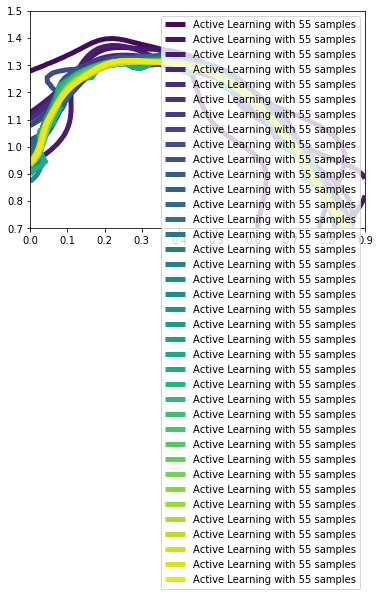

In [39]:
from IPython.display import clear_output
# ITERATIONS = (50-5) // 5
ITERATIONS = (195-5) // 5

cmap = RGBAContinuousTransformer('viridis', ITERATIONS)
cmap.fit(np.array([0, ITERATIONS]))
mis_classify_lst2 = []
np.random.seed(13777)
for i in tqdm(range(ITERATIONS)):
    myProblem_batch.run_optimization(max_iter=1) 
#     myProblem.plot_acquisition('{}.pdf'.format(i))
#     if i % 3 == 0:
    mis_classify_lst2.append(plot_contour(myProblem_batch, obj, i, cmap, precision=50))
    plt.xlim(LJ_BOUNDS[0])
    plt.ylim(LJ_BOUNDS[1])

# get output for first 50 samples from the actual 195 samples model

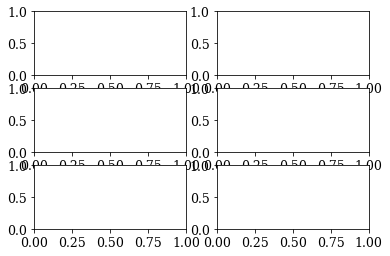

In [125]:
fig, axes = plt.subplots(nrows=3, ncols=2)

r
[ 0.25475212]
r
[ 0.25475212  0.25475212]
r
[ 0.25475212  0.25475212  0.25475212]
r
[ 0.25475212  0.25475212  0.25475212  0.25475212]


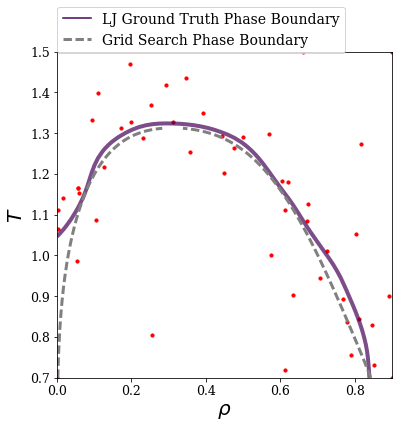

In [155]:
bounds = [{'name': 'Density (r)', 'type': 'continuous', 'domain': LJ_BOUNDS[0]},
          {'name': 'Temperature (T)', 'type': 'continuous', 'domain': LJ_BOUNDS[1]}]

tmp_prob = BayesianOptimization(myf, bounds, acquisition_type="BinaryT",
                                X = myProblem_batch.X[:50,:],
                                evaluator_type = 'local_penalization',
                                batch_size = 5,
                                num_cores = 1,)

plt.figure(figsize=(6,6))
precision = 50
colormap = cmap
ite = 0

bounds = tmp_prob.space.get_bounds()
gridx = np.linspace(bounds[0][0], bounds[0][1], precision)
gridy = np.linspace(bounds[1][0], bounds[1][1], precision)

xv, yv = np.meshgrid(gridx, gridy)
zv = np.zeros((precision, precision))
true_zv = np.zeros((precision, precision))

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(tmp_prob.X, tmp_prob.Y)

for i in range(len(xv)):
    for j in range(len(xv)):
        zv[i,j] = tmp_prob.model.predict(np.array([xv[i,j],yv[i,j]]).T)[0]
#             zv[i,j] = knn.predict(np.array([xv[i,j],yv[i,j]]).reshape((1,-1)))[0]
        true_zv[i,j] = obj.f(np.array([[xv[i,j],yv[i,j]]]))
ct = plt.contour(xv, yv, zv,levels=[0], colors=colormap.transform(np.array([ite])), linewidths=4, alpha=0.7)
ct.collections[0].set_label('Active Learning with 50 samples')

# plt.title('(a)', loc='left')

gt, = plt.plot(lj['r* (vapor)'], lj['T*'], 'g--', color='gray', linewidth=3, label='Ground Truth Phase Boundary')
plt.plot(lj['r* (liquid)'], lj['T*'], 'g--', color='gray', linewidth=3)

plt.xlim(LJ_BOUNDS[0])
plt.ylim(LJ_BOUNDS[1])
plt.xlabel('$\\rho$', fontsize=20)
plt.ylabel('$T$', fontsize=20)
dots = plt.scatter(tmp_prob.X[:,0], tmp_prob.X[:,1], s=10, color='r', label='Sampled Statepoints')

# plt.colorbar()
purple = mlines.Line2D([], [], color=[ 0.26851 ,  0.009605,  0.335427,  1.      ],
                          markersize=15, label='Active Learning (Batch) Phase Boundary')
plt.figlegend(handles=[purple, gt,], 
              labels=['LJ Ground Truth Phase Boundary', 'Grid Search Phase Boundary'],
              loc=9,
              fontsize=14)
# dot = mlines.
# plt.legend(handles=[purple, gt], loc='lower left', fontsize=13, frameon=False)
# plt.tight_layout()
plt.savefig('AL_batch_50.png'.format(i), dpi=200)

# Get Full model output

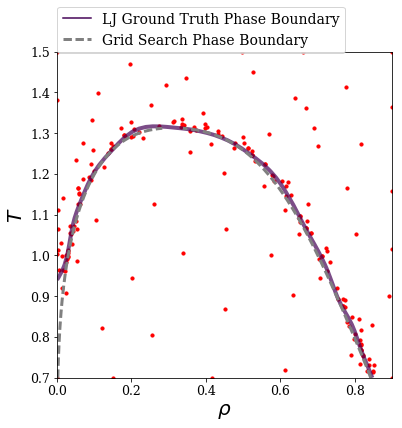

In [154]:
tmp_prob = myProblem_batch

plt.figure(figsize=(6,6))
precision = 50
colormap = cmap
ite = 0

bounds = tmp_prob.space.get_bounds()
gridx = np.linspace(bounds[0][0], bounds[0][1], precision)
gridy = np.linspace(bounds[1][0], bounds[1][1], precision)

xv, yv = np.meshgrid(gridx, gridy)
zv = np.zeros((precision, precision))
true_zv = np.zeros((precision, precision))

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(tmp_prob.X, tmp_prob.Y)

for i in range(len(xv)):
    for j in range(len(xv)):
        zv[i,j] = tmp_prob.model.predict(np.array([xv[i,j],yv[i,j]]).T)[0]
#             zv[i,j] = knn.predict(np.array([xv[i,j],yv[i,j]]).reshape((1,-1)))[0]
        true_zv[i,j] = obj.f(np.array([[xv[i,j],yv[i,j]]]))
ct = plt.contour(xv, yv, zv,levels=[0], colors=colormap.transform(np.array([ite])), linewidths=4, alpha=0.7)
ct.collections[0].set_label('Active Learning with 50 samples')

# plt.title('(a)', loc='left')

gt, = plt.plot(lj['r* (vapor)'], lj['T*'], 'g--', color='gray', linewidth=3, label='Ground Truth Phase Boundary')
plt.plot(lj['r* (liquid)'], lj['T*'], 'g--', color='gray', linewidth=3)

plt.xlim(LJ_BOUNDS[0])
plt.ylim(LJ_BOUNDS[1])
plt.xlabel('$\\rho$', fontsize=20)
plt.ylabel('$T$', fontsize=20)
dots = plt.scatter(tmp_prob.X[:,0], tmp_prob.X[:,1], s=10, color='r', label='Sampled Statepoints')

# plt.colorbar()
purple = mlines.Line2D([], [], color=[ 0.26851 ,  0.009605,  0.335427,  1.      ],
                          markersize=15, label='Active Learning (Batch) Phase Boundary')
plt.figlegend(handles=[purple, gt,], 
              labels=['LJ Ground Truth Phase Boundary', 'Grid Search Phase Boundary'],
              loc=9,
              fontsize=14)
# dot = mlines.
# plt.legend(handles=[purple, gt], loc='lower left', fontsize=13, frameon=False)
# plt.tight_layout()

plt.savefig('AL_batch_195.png'.format(i), dpi=200)

# no batch

In [48]:
bounds = [{'name': 'Density (r)', 'type': 'continuous', 'domain': LJ_BOUNDS[0]},
          {'name': 'Temperature (T)', 'type': 'continuous', 'domain': LJ_BOUNDS[1]}]
np.random.seed(13777)
myProblem = BayesianOptimization(myf,bounds,acquisition_type="BinaryT",
                                 evaluator_type = 'local_penalization',
                                 batch_size = 1,
                                 num_cores = 1,
                                 X = init,
                                 exact_feval = False)

In [49]:
# init = myProblem.X[:5]
mis_classify_lst = []

In [50]:
# bounds = [{'name': 'Density (r)', 'type': 'continuous', 'domain': LJ_BOUNDS[0]},
#           {'name': 'Temperature (T)', 'type': 'continuous', 'domain': LJ_BOUNDS[1]}]
# myProblem_tmp = BayesianOptimization(myf,bounds,acquisition_type="BinaryT",
#                                  evaluator_type = 'local_penalization',
#                                  batch_size = 1,
#                                  num_cores = 1,
#                                  X = init,
#                                  exact_feval = False)
# loss = plot_contour(myProblem_tmp, obj, i, cmap, precision=50)
# mis_classify_lst.insert(0, loss)
# mis_classify_lst2.insert(0, loss)

100%|██████████| 190/190 [06:44<00:00,  2.56s/it]


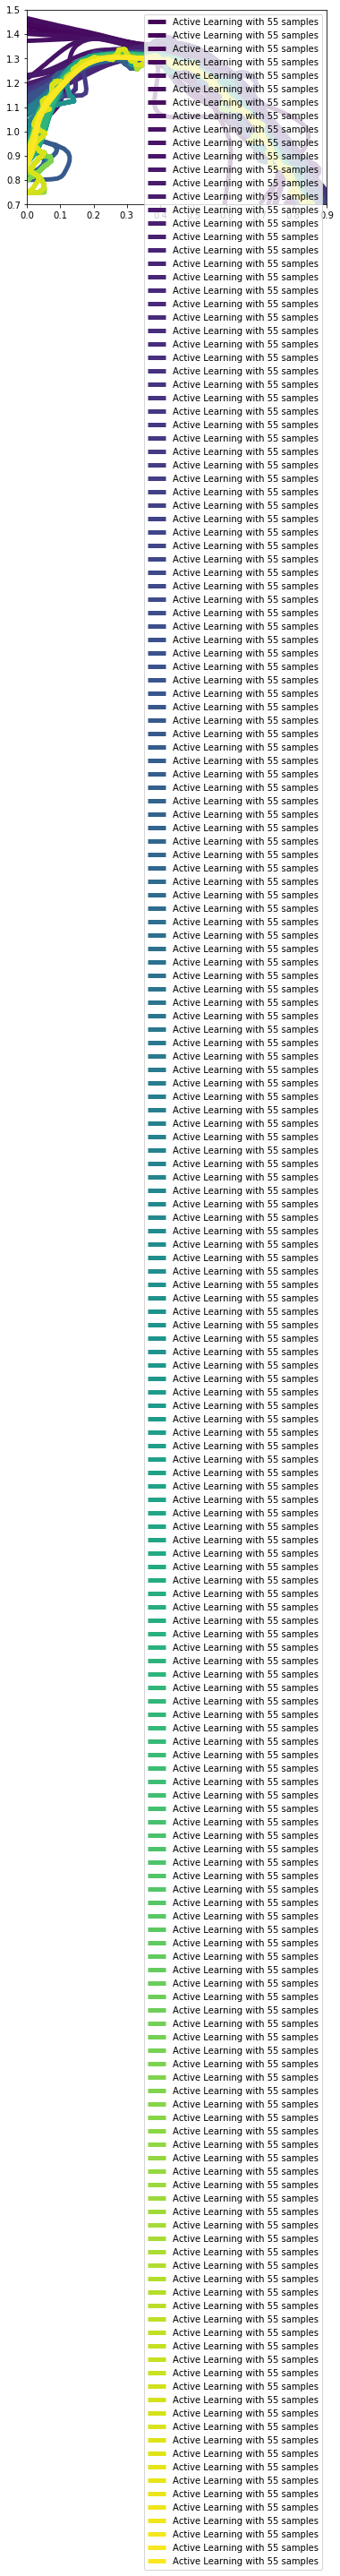

In [51]:
from IPython.display import clear_output

ITERATIONS = 190

np.random.seed(13777)

cmap = RGBAContinuousTransformer('viridis', ITERATIONS)
cmap.fit(np.array([0, ITERATIONS]))
for i in tqdm(range(ITERATIONS)):
    myProblem.run_optimization(max_iter=1) 
#     myProblem.plot_acquisition('{}.pdf'.format(i))
#     if i % 10 == 0:
    mis_classify_lst.append(plot_contour(myProblem, obj, i, cmap, precision=50))

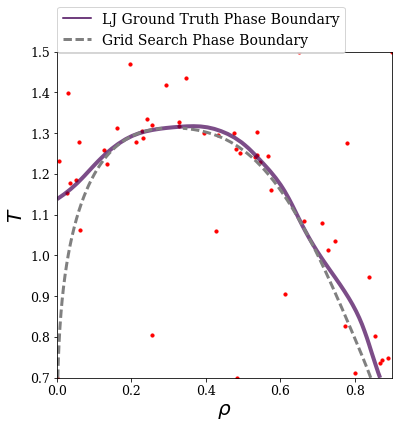

In [158]:
bounds = [{'name': 'Density (r)', 'type': 'continuous', 'domain': LJ_BOUNDS[0]},
          {'name': 'Temperature (T)', 'type': 'continuous', 'domain': LJ_BOUNDS[1]}]

tmp_prob = BayesianOptimization(myf, bounds, acquisition_type="BinaryT",
                                X = myProblem.X[:50,:],
                                evaluator_type = 'local_penalization',
                                batch_size = 1,
                                num_cores = 1,)

plt.figure(figsize=(6,6))
precision = 50
colormap = cmap
ite = 0

bounds = tmp_prob.space.get_bounds()
gridx = np.linspace(bounds[0][0], bounds[0][1], precision)
gridy = np.linspace(bounds[1][0], bounds[1][1], precision)

xv, yv = np.meshgrid(gridx, gridy)
zv = np.zeros((precision, precision))
true_zv = np.zeros((precision, precision))

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(tmp_prob.X, tmp_prob.Y)

for i in range(len(xv)):
    for j in range(len(xv)):
        zv[i,j] = tmp_prob.model.predict(np.array([xv[i,j],yv[i,j]]).T)[0]
#             zv[i,j] = knn.predict(np.array([xv[i,j],yv[i,j]]).reshape((1,-1)))[0]
        true_zv[i,j] = obj.f(np.array([[xv[i,j],yv[i,j]]]))
ct = plt.contour(xv, yv, zv,levels=[0], colors=colormap.transform(np.array([ite])), linewidths=4, alpha=0.7)
ct.collections[0].set_label('Active Learning with 50 samples')

# plt.title('(a)', loc='left')

gt, = plt.plot(lj['r* (vapor)'], lj['T*'], 'g--', color='gray', linewidth=3, label='Ground Truth Phase Boundary')
plt.plot(lj['r* (liquid)'], lj['T*'], 'g--', color='gray', linewidth=3)

plt.xlim(LJ_BOUNDS[0])
plt.ylim(LJ_BOUNDS[1])
plt.xlabel('$\\rho$', fontsize=20)
plt.ylabel('$T$', fontsize=20)
dots = plt.scatter(tmp_prob.X[:,0], tmp_prob.X[:,1], s=10, color='r', label='Sampled Statepoints')

# plt.colorbar()
purple = mlines.Line2D([], [], color=[ 0.26851 ,  0.009605,  0.335427,  1.      ],
                          markersize=15, label='Active Learning (Seq) Phase Boundary')
plt.figlegend(handles=[purple, gt,], 
              labels=['LJ Ground Truth Phase Boundary', 'Grid Search Phase Boundary'],
              loc=9,
              fontsize=14)
# dot = mlines.
# plt.legend(handles=[purple, gt], loc='lower left', fontsize=13, frameon=False)
# plt.tight_layout()
plt.savefig('AL_seq_50.png'.format(i), dpi=200)

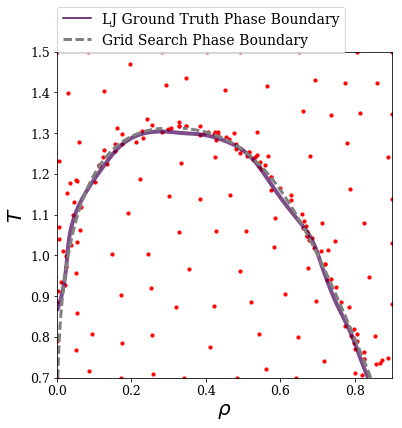

In [152]:
tmp_prob = myProblem

plt.figure(figsize=(6,6))
precision = 50
colormap = cmap
ite = 0

bounds = tmp_prob.space.get_bounds()
gridx = np.linspace(bounds[0][0], bounds[0][1], precision)
gridy = np.linspace(bounds[1][0], bounds[1][1], precision)

xv, yv = np.meshgrid(gridx, gridy)
zv = np.zeros((precision, precision))
true_zv = np.zeros((precision, precision))

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(tmp_prob.X, tmp_prob.Y)

for i in range(len(xv)):
    for j in range(len(xv)):
        zv[i,j] = tmp_prob.model.predict(np.array([xv[i,j],yv[i,j]]).T)[0]
#             zv[i,j] = knn.predict(np.array([xv[i,j],yv[i,j]]).reshape((1,-1)))[0]
        true_zv[i,j] = obj.f(np.array([[xv[i,j],yv[i,j]]]))
ct = plt.contour(xv, yv, zv,levels=[0], colors=colormap.transform(np.array([ite])), linewidths=4, alpha=0.7)
ct.collections[0].set_label('Active Learning with 50 samples')

# plt.title('(a)', loc='left')

gt, = plt.plot(lj['r* (vapor)'], lj['T*'], 'g--', color='gray', linewidth=3, label='Ground Truth Phase Boundary')
plt.plot(lj['r* (liquid)'], lj['T*'], 'g--', color='gray', linewidth=3)

plt.xlim(LJ_BOUNDS[0])
plt.ylim(LJ_BOUNDS[1])
plt.xlabel('$\\rho$', fontsize=20)
plt.ylabel('$T$', fontsize=20)
dots = plt.scatter(tmp_prob.X[:,0], tmp_prob.X[:,1], s=10, color='r', label='Sampled Statepoints')

# plt.colorbar()
purple = mlines.Line2D([], [], color=[ 0.26851 ,  0.009605,  0.335427,  1.      ],
                          markersize=15, label='Active Learning (Seq) Phase Boundary')
plt.figlegend(handles=[purple, gt,], 
              labels=['LJ Ground Truth Phase Boundary', 'Grid Search Phase Boundary'],
              loc=9,
              fontsize=14)
# dot = mlines.
# plt.legend(handles=[purple, gt], loc='lower left', fontsize=13, frameon=False)
# plt.tight_layout()
plt.savefig('AL_seq_195.png'.format(i), dpi=200)

In [ ]:
myProblem

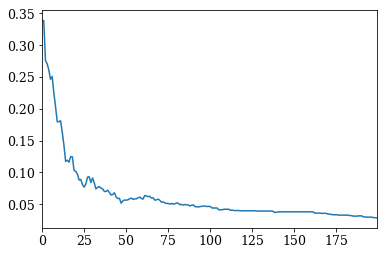

In [56]:
import pandas as pd
pd.Series(mis_classify_lst).plot()

# grid search

In [58]:
from sklearn.neighbors import KNeighborsClassifier

def grid_search(myProblem, obj, grid_precision, eval_precision = 50):
    bounds = myProblem.space.get_bounds()
    obsx = np.linspace(bounds[0][0], bounds[0][1], grid_precision)
    obsy = np.linspace(bounds[1][0], bounds[1][1], grid_precision)

    evalx = np.linspace(bounds[0][0], bounds[0][1], eval_precision)
    evaly = np.linspace(bounds[1][0], bounds[1][1], eval_precision)

    xv, yv = np.meshgrid(obsx, obsy)
    xv_eval, yv_eval = np.meshgrid(evalx, evaly)
    knn = KNeighborsClassifier(n_neighbors=1)
    zv = np.zeros((grid_precision, grid_precision))

    for i in range(len(obsx)):
        for j in range(len(obsx)):
            zv[i,j] = obj.f(np.array([[xv[i,j],yv[i,j]]]))

    knn.fit(np.vstack([xv.ravel(), yv.ravel()]).T, zv.ravel())
    true_zv = np.zeros((eval_precision, eval_precision))
    zv_eval = np.zeros((eval_precision, eval_precision))
    for i in range(len(xv_eval)):
        for j in range(len(xv_eval)):
            zv_eval[i,j] = knn.predict(np.array([xv_eval[i,j],yv_eval[i,j]]).reshape((1,-1)))[0]
            true_zv[i,j] = obj.f(np.array([[xv_eval[i,j],yv_eval[i,j]]]))

    plt.contour(xv, yv, zv,levels=[0])

    # round zv to int value
    zv_eval = (zv_eval>0) * 2 - 1

    num_data = grid_precision ** 2
    miss_rate = np.sum(zv_eval!=true_zv) / eval_precision**2
    return num_data, miss_rate

In [59]:
cmap.transform(np.array([0]))

array([[ 0.26851 ,  0.009605,  0.335427,  1.      ]])

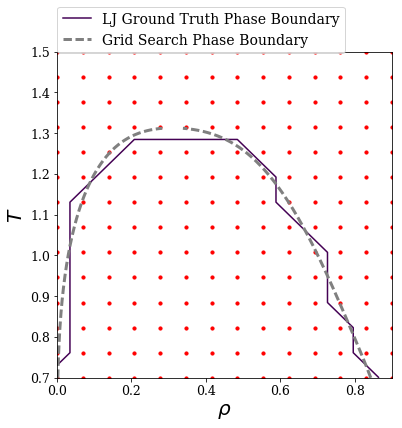

In [159]:
i = 14
# i = 7

plt.figure(figsize=(6,6))
grid_search(myProblem, obj, i, eval_precision = 10)

evalx = np.linspace(LJ_BOUNDS[0][0], LJ_BOUNDS[0][1], i)
evaly = np.linspace(LJ_BOUNDS[1][0], LJ_BOUNDS[1][1], i)
xv_eval, yv_eval = np.meshgrid(evalx, evaly)
dots = plt.scatter(xv_eval, yv_eval, s=10, c='r', label='Sampled Statepoints')

plt.xlim(LJ_BOUNDS[0])
plt.ylim(LJ_BOUNDS[1])
plt.xlabel('$\\rho$', fontsize=20)
plt.ylabel('$T$', fontsize=20)

# plot lj ground truth
gt, = plt.plot(lj['r* (vapor)'], lj['T*'], '--', color='gray', linewidth=3, label='LJ Ground Truth Phase Boundary')
plt.plot(lj['r* (liquid)'], lj['T*'], '--', color='gray', linewidth=3)

# legend:
purple = mlines.Line2D([], [], color=[ 0.26851 ,  0.009605,  0.335427,  1.      ],
                          markersize=15, label='Grid Search Phase Boundary')

# dot = mlines.
# lgd = plt.legend(handles=[purple, gt], mode="expand", fontsize=13, frameon=False)
# lgd = plt.legend(handles=[purple, gt], loc='lower left', fontsize=13, shadow=False)
# lgd.get_frame().set_facecolor('white')

# plt.figlegend(handles=[purple, gt, dots], 
#               labels=['LJ Ground Truth Phase Boundary', 'Grid Search Phase Boundary', 'Sampled Statepoints'],
#               loc=9,
#               fontsize=13, frameon=False)

plt.figlegend(handles=[purple, gt,], 
              labels=['LJ Ground Truth Phase Boundary', 'Grid Search Phase Boundary'],
              loc=9,
              fontsize=14)

# plt.tight_layout()

plt.savefig('grid_search_{}.png'.format(i), dpi=200)

# composite figure

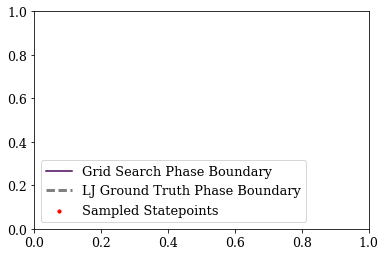

In [122]:
lgd = plt.legend(handles=[purple, gt, dots], loc='lower left', fontsize=13, shadow=False)


 38%|███▊      | 5/13 [00:07<00:12,  1.53s/it]


KeyboardInterrupt: 

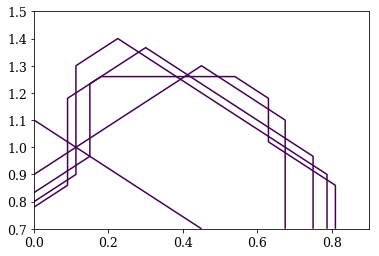

In [82]:
num_data_lst = []
miss_rate_lst = []
for i in tqdm(range(2,15)):
    num_data, miss_rate = grid_search(myProblem, obj, i)
    num_data_lst.append(num_data)
    miss_rate_lst.append(miss_rate)

In [ ]:
plot(num_data_lst, np.log(miss_rate_lst))
plot(range(5,5+ITERATIONS), np.log(mis_classify_lst))

In [ ]:
# np.save('num_data_lst', np.array(num_data_lst),)
# np.save('miss_classify_grid', np.array(mis_classify_lst))
# np.save('miss_classify_active', np.array(miss_rate_lst))

In [91]:
num_data_lst = np.load('num_data_lst.npy')
mis_classify_lst = np.load('miss_classify_grid.npy')
miss_rate_lst = np.load('miss_classify_active.npy')

In [92]:
mis_classify_lst2.insert(0, mis_classify_lst[0])

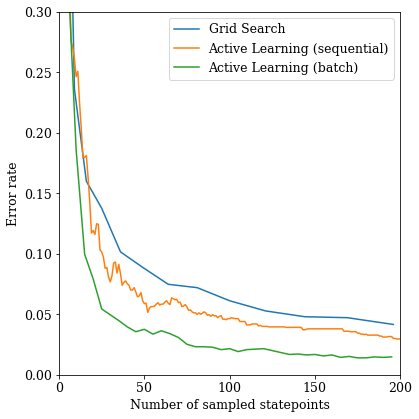

In [99]:
import matplotlib 
plt.figure(figsize=(6,6), )
# plt.axis('equal')
matplotlib.rc('xtick', labelsize=12.5) 
matplotlib.rc('ytick', labelsize=12.5)
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12.5}

matplotlib.rc('font', **font)

plot(num_data_lst, (miss_rate_lst))
plot(range(5,5+len(mis_classify_lst)), (mis_classify_lst))

# for batch
# plot(range(5,5+len(mis_classify_lst2)*5, 5), (mis_classify_lst2))


plot(range(5,5+len(mis_classify_lst2)*5, 5), (mis_classify_lst2))
plt.ylim(0,0.3)

plt.xticks([0,50,100,150,200])
plt.legend(['Grid Search', 'Active Learning (sequential)', 'Active Learning (batch)'])
plt.xlabel('Number of sampled statepoints')
plt.ylabel('Error rate')
# plt.title('(b)', loc='left')
# plot(range(200), [0.05]*200,'--')
plt.xlim(0,200)
plt.tight_layout()
plt.savefig('rate_lj.png', dpi=200)

In [102]:
# mis_classify_lst.insert(0, mis_classify_lst2[0])

In [55]:
num_data_lst

array([  4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144, 169, 196])

In [61]:
list(range(5,5+len(miss_rate_lst)*5, 5))

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]